In [21]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin

In [22]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [24]:
## loading BreastMNIST dataset
data_flag = 'breastmnist'
download = True
BATCH_SIZE = 64
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

from sklearn.metrics import roc_auc_score

SEED = 123
BATCH_SIZE = 128
imratio = 0.1  # for demo
total_epochs = 120
decay_epochs = [50, 75]

# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform_train = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the data
train_dataset = DataClass(split='train', transform=transform_train, download=download)
test_dataset = DataClass(split='test', transform=transform_test, download=download)
val_dataset = DataClass(split='val', transform=transform_val, download=download)

# # Combine training and validation datasets for constructing a validation set
# train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# # Split the combined dataset into training and validation sets
# train_size = int(0.8 * len(train_val_dataset))
# val_size = len(train_val_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)



# Instantiate the ResNet-18 model[Single Channel] and set it to training mode
from libauc.models import resnet18 as ResNet18

model = ResNet18(pretrained=False)
model = model.cuda()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2)
)

# # Define loss function and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, loss_fn=loss_fn, momentum=0.9, margin=1.0, epoch_decay=0.03, lr=0.1, weight_decay=1e-7)


# Set early stopping parameters
early_stop_epochs = 100  # Stop if validation AUC does not improve for 10 epochs
best_val_auc = 0
best_test_auc = 0
epochs_since_last_improvement = 0

# Training loop
print ('Start Training')
print ('-'*30)

train_log = []
test_log = []
val_log = []
for epoch in range(total_epochs):
  
     train_loss = []
     model = model.cuda()
     model.train()    
     for data, targets in tqdm(train_loader):
         data, targets = data.cuda(), targets.cuda()
         y_pred = model(data)
         loss = loss_fn(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_loss.append(loss.item())
     
     # evaluation on train & test sets
     model.eval()
     train_pred_list = []
     train_true_list = []
     for train_data, train_targets in train_loader_at_eval:
         train_data = train_data.cuda()
         train_pred = model(train_data)
         train_pred_list.append(train_pred.cpu().detach().numpy())
         train_true_list.append(train_targets.numpy())
     train_true = np.concatenate(train_true_list)
     train_pred = np.concatenate(train_pred_list)
     train_auc = auc_roc_score(train_true, train_pred)
     train_loss = np.mean(train_loss)

     val_pred_list = []
     val_true_list = [] 
     for val_data, val_targets in val_loader:
         val_data = val_data.cuda()
         val_pred = model(val_data)
         val_pred_list.append(val_pred.cpu().detach().numpy())
         val_true_list.append(val_targets.numpy())
     val_true = np.concatenate(val_true_list)
     val_pred = np.concatenate(val_pred_list)
     val_auc =  auc_roc_score(val_true, val_pred) 

     test_pred_list = []
     test_true_list = [] 
     for test_data, test_targets in test_loader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
     test_true = np.concatenate(test_true_list)
     test_pred = np.concatenate(test_pred_list)
     test_auc =  auc_roc_score(test_true, test_pred) 
     model.train()

     # print results
     print("epoch: %s, train_loss: %.4f, train_auc: %.4f, val_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.param_groups[0]['lr']))    
     train_log.append(train_auc[0]) 
     test_log.append(test_auc[0])
     val_log.append(val_auc[0])

     # Check for early stopping
     if val_auc[0] > best_val_auc:
        best_val_auc = val_auc[0] 
        best_test_auc = test_auc[0] #Test AUC corresponding to best Val AUC
        epochs_since_last_improvement = 0       
     else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= early_stop_epochs:
            print(f"No improvement in validation AUC for {early_stop_epochs} epochs. Training stopped early.")
            break


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Start Training
------------------------------


100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


epoch: 0, train_loss: 33.7531, train_auc: 0.6404, val_auc: 0.6324, test_auc: 0.6287, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 16.85it/s]


epoch: 1, train_loss: 0.7298, train_auc: 0.3660, val_auc: 0.3450, test_auc: 0.3799, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 17.40it/s]


epoch: 2, train_loss: 0.5009, train_auc: 0.5134, val_auc: 0.4503, test_auc: 0.5276, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.91it/s]


epoch: 3, train_loss: 0.2350, train_auc: 0.5947, val_auc: 0.6834, test_auc: 0.6199, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


epoch: 4, train_loss: 0.3174, train_auc: 0.6880, val_auc: 0.7377, test_auc: 0.7483, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


epoch: 5, train_loss: 0.1639, train_auc: 0.6856, val_auc: 0.7302, test_auc: 0.7634, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


epoch: 6, train_loss: 0.1484, train_auc: 0.6860, val_auc: 0.7218, test_auc: 0.7588, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


epoch: 7, train_loss: 0.1594, train_auc: 0.7106, val_auc: 0.7318, test_auc: 0.7711, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


epoch: 8, train_loss: 0.1500, train_auc: 0.6961, val_auc: 0.7327, test_auc: 0.7592, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.51it/s]


epoch: 9, train_loss: 0.1481, train_auc: 0.7273, val_auc: 0.7410, test_auc: 0.7853, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 13.99it/s]


epoch: 10, train_loss: 0.1415, train_auc: 0.6947, val_auc: 0.7368, test_auc: 0.7625, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


epoch: 11, train_loss: 0.1531, train_auc: 0.7302, val_auc: 0.7385, test_auc: 0.7838, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


epoch: 12, train_loss: 0.1366, train_auc: 0.7509, val_auc: 0.7694, test_auc: 0.8016, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 13.93it/s]


epoch: 13, train_loss: 0.1218, train_auc: 0.7607, val_auc: 0.7744, test_auc: 0.8087, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


epoch: 14, train_loss: 0.1159, train_auc: 0.7830, val_auc: 0.7911, test_auc: 0.8229, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.10it/s]


epoch: 15, train_loss: 0.0966, train_auc: 0.7887, val_auc: 0.7870, test_auc: 0.8256, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


epoch: 16, train_loss: 0.1056, train_auc: 0.7906, val_auc: 0.8003, test_auc: 0.8306, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.21it/s]


epoch: 17, train_loss: 0.1022, train_auc: 0.8205, val_auc: 0.8053, test_auc: 0.8394, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.40it/s]


epoch: 18, train_loss: 0.0854, train_auc: 0.8243, val_auc: 0.8058, test_auc: 0.8459, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


epoch: 19, train_loss: 0.0969, train_auc: 0.8318, val_auc: 0.8454, test_auc: 0.8561, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.46it/s]


epoch: 20, train_loss: 0.0999, train_auc: 0.8325, val_auc: 0.8287, test_auc: 0.8350, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


epoch: 21, train_loss: 0.0944, train_auc: 0.8580, val_auc: 0.8463, test_auc: 0.8743, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.70it/s]


epoch: 22, train_loss: 0.0898, train_auc: 0.8383, val_auc: 0.8363, test_auc: 0.8559, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


epoch: 23, train_loss: 0.0720, train_auc: 0.8363, val_auc: 0.8346, test_auc: 0.8534, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.98it/s]


epoch: 24, train_loss: 0.0967, train_auc: 0.8444, val_auc: 0.8496, test_auc: 0.8757, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.46it/s]


epoch: 25, train_loss: 0.0832, train_auc: 0.8551, val_auc: 0.8596, test_auc: 0.8421, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.99it/s]


epoch: 26, train_loss: 0.0639, train_auc: 0.8363, val_auc: 0.8179, test_auc: 0.8580, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


epoch: 27, train_loss: 0.1148, train_auc: 0.8717, val_auc: 0.8463, test_auc: 0.8415, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.15it/s]


epoch: 28, train_loss: 0.0765, train_auc: 0.8598, val_auc: 0.8755, test_auc: 0.8532, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


epoch: 29, train_loss: 0.0509, train_auc: 0.8225, val_auc: 0.8371, test_auc: 0.8081, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


epoch: 30, train_loss: 0.0939, train_auc: 0.8798, val_auc: 0.8647, test_auc: 0.8810, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.12it/s]


epoch: 31, train_loss: 0.0752, train_auc: 0.8153, val_auc: 0.8095, test_auc: 0.8235, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


epoch: 32, train_loss: 0.0510, train_auc: 0.8435, val_auc: 0.8429, test_auc: 0.8505, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


epoch: 33, train_loss: 0.0531, train_auc: 0.8354, val_auc: 0.8396, test_auc: 0.8446, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 17.08it/s]


epoch: 34, train_loss: 0.0561, train_auc: 0.9130, val_auc: 0.8772, test_auc: 0.9064, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.76it/s]


epoch: 35, train_loss: 0.0511, train_auc: 0.9089, val_auc: 0.8772, test_auc: 0.8803, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.60it/s]


epoch: 36, train_loss: 0.0443, train_auc: 0.8822, val_auc: 0.8446, test_auc: 0.8429, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.07it/s]


epoch: 37, train_loss: 0.0552, train_auc: 0.9125, val_auc: 0.8881, test_auc: 0.8736, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 17.04it/s]


epoch: 38, train_loss: 0.0419, train_auc: 0.8366, val_auc: 0.8246, test_auc: 0.7987, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


epoch: 39, train_loss: 0.0546, train_auc: 0.7940, val_auc: 0.7769, test_auc: 0.7602, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.36it/s]


epoch: 40, train_loss: 0.0491, train_auc: 0.9269, val_auc: 0.8663, test_auc: 0.8693, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


epoch: 41, train_loss: 0.0303, train_auc: 0.9163, val_auc: 0.8713, test_auc: 0.8622, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


epoch: 42, train_loss: 0.0560, train_auc: 0.9310, val_auc: 0.8922, test_auc: 0.8764, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


epoch: 43, train_loss: 0.0381, train_auc: 0.8820, val_auc: 0.8454, test_auc: 0.8083, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.22it/s]


epoch: 44, train_loss: 0.0335, train_auc: 0.8230, val_auc: 0.8246, test_auc: 0.7834, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.91it/s]


epoch: 45, train_loss: 0.0435, train_auc: 0.8631, val_auc: 0.8488, test_auc: 0.7962, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


epoch: 46, train_loss: 0.0534, train_auc: 0.9530, val_auc: 0.8922, test_auc: 0.8822, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.13it/s]


epoch: 47, train_loss: 0.0116, train_auc: 0.9478, val_auc: 0.8722, test_auc: 0.8659, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


epoch: 48, train_loss: 0.0321, train_auc: 0.9010, val_auc: 0.8713, test_auc: 0.7978, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


epoch: 49, train_loss: 0.0242, train_auc: 0.9639, val_auc: 0.8989, test_auc: 0.8709, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


epoch: 50, train_loss: 0.0155, train_auc: 0.9577, val_auc: 0.8789, test_auc: 0.8682, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


epoch: 51, train_loss: 0.0392, train_auc: 0.9172, val_auc: 0.8521, test_auc: 0.8553, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


epoch: 52, train_loss: 0.0416, train_auc: 0.9349, val_auc: 0.8580, test_auc: 0.8580, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.44it/s]


epoch: 53, train_loss: 0.0242, train_auc: 0.9523, val_auc: 0.9165, test_auc: 0.8711, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


epoch: 54, train_loss: 0.0222, train_auc: 0.9530, val_auc: 0.8922, test_auc: 0.8532, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


epoch: 55, train_loss: 0.0189, train_auc: 0.9425, val_auc: 0.8914, test_auc: 0.8304, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.06it/s]


epoch: 56, train_loss: 0.0364, train_auc: 0.9697, val_auc: 0.8981, test_auc: 0.8657, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.62it/s]


epoch: 57, train_loss: 0.0209, train_auc: 0.9072, val_auc: 0.8830, test_auc: 0.7982, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.17it/s]


epoch: 58, train_loss: 0.0236, train_auc: 0.9727, val_auc: 0.8972, test_auc: 0.8745, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


epoch: 59, train_loss: 0.0130, train_auc: 0.8454, val_auc: 0.8321, test_auc: 0.7759, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.37it/s]


epoch: 60, train_loss: 0.0553, train_auc: 0.9731, val_auc: 0.9156, test_auc: 0.8803, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.74it/s]


epoch: 61, train_loss: 0.0218, train_auc: 0.9316, val_auc: 0.8814, test_auc: 0.8191, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


epoch: 62, train_loss: 0.0164, train_auc: 0.9792, val_auc: 0.8889, test_auc: 0.8730, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 17.83it/s]


epoch: 63, train_loss: 0.0053, train_auc: 0.9744, val_auc: 0.9073, test_auc: 0.8816, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


epoch: 64, train_loss: 0.0068, train_auc: 0.9543, val_auc: 0.8705, test_auc: 0.8315, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


epoch: 65, train_loss: 0.0177, train_auc: 0.9801, val_auc: 0.9190, test_auc: 0.8578, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


epoch: 66, train_loss: 0.0045, train_auc: 0.9863, val_auc: 0.9064, test_auc: 0.8816, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


epoch: 67, train_loss: 0.0062, train_auc: 0.9887, val_auc: 0.9114, test_auc: 0.8603, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.27it/s]


epoch: 68, train_loss: 0.0034, train_auc: 0.9619, val_auc: 0.8872, test_auc: 0.8486, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


epoch: 69, train_loss: 0.0108, train_auc: 0.9087, val_auc: 0.8805, test_auc: 0.7726, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


epoch: 70, train_loss: 0.0296, train_auc: 0.8710, val_auc: 0.8471, test_auc: 0.7650, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


epoch: 71, train_loss: 0.0223, train_auc: 0.9714, val_auc: 0.9098, test_auc: 0.8354, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.41it/s]


epoch: 72, train_loss: 0.0043, train_auc: 0.9915, val_auc: 0.9064, test_auc: 0.8674, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


epoch: 73, train_loss: 0.0103, train_auc: 0.9339, val_auc: 0.8772, test_auc: 0.7924, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.16it/s]


epoch: 74, train_loss: 0.0230, train_auc: 0.8684, val_auc: 0.8404, test_auc: 0.7763, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.59it/s]


epoch: 75, train_loss: 0.0578, train_auc: 0.9411, val_auc: 0.9089, test_auc: 0.8277, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


epoch: 76, train_loss: 0.0188, train_auc: 0.9731, val_auc: 0.9048, test_auc: 0.8519, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


epoch: 77, train_loss: 0.0145, train_auc: 0.9815, val_auc: 0.8989, test_auc: 0.8244, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.81it/s]


epoch: 78, train_loss: 0.0098, train_auc: 0.9644, val_auc: 0.8580, test_auc: 0.8375, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


epoch: 79, train_loss: 0.0086, train_auc: 0.9926, val_auc: 0.9114, test_auc: 0.8874, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


epoch: 80, train_loss: 0.0084, train_auc: 0.8733, val_auc: 0.7778, test_auc: 0.7774, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.77it/s]


epoch: 81, train_loss: 0.0327, train_auc: 0.9804, val_auc: 0.9023, test_auc: 0.8630, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


epoch: 82, train_loss: 0.0116, train_auc: 0.9740, val_auc: 0.9073, test_auc: 0.8469, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.30it/s]


epoch: 83, train_loss: 0.0154, train_auc: 0.9261, val_auc: 0.8705, test_auc: 0.8039, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 16.12it/s]


epoch: 84, train_loss: 0.0149, train_auc: 0.9923, val_auc: 0.9298, test_auc: 0.8590, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.95it/s]


epoch: 85, train_loss: 0.0022, train_auc: 0.9887, val_auc: 0.9148, test_auc: 0.8574, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.12it/s]


epoch: 86, train_loss: 0.0078, train_auc: 0.9607, val_auc: 0.8338, test_auc: 0.8118, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


epoch: 87, train_loss: 0.0060, train_auc: 0.9849, val_auc: 0.9031, test_auc: 0.8465, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.60it/s]


epoch: 88, train_loss: 0.0094, train_auc: 0.9593, val_auc: 0.8739, test_auc: 0.8283, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.05it/s]


epoch: 89, train_loss: 0.0079, train_auc: 0.9912, val_auc: 0.9248, test_auc: 0.8592, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.20it/s]


epoch: 90, train_loss: 0.0029, train_auc: 0.9952, val_auc: 0.9256, test_auc: 0.8605, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.67it/s]


epoch: 91, train_loss: 0.0024, train_auc: 0.9934, val_auc: 0.9156, test_auc: 0.8571, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.68it/s]


epoch: 92, train_loss: 0.0032, train_auc: 0.9846, val_auc: 0.9298, test_auc: 0.8411, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.03it/s]


epoch: 93, train_loss: 0.0022, train_auc: 0.9985, val_auc: 0.9215, test_auc: 0.8609, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.39it/s]


epoch: 94, train_loss: 0.0022, train_auc: 0.9994, val_auc: 0.9181, test_auc: 0.8759, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.49it/s]


epoch: 95, train_loss: 0.0016, train_auc: 0.9953, val_auc: 0.9223, test_auc: 0.8632, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 20.21it/s]


epoch: 96, train_loss: 0.0020, train_auc: 0.9963, val_auc: 0.9256, test_auc: 0.8607, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.38it/s]


epoch: 97, train_loss: 0.0019, train_auc: 0.9995, val_auc: 0.9198, test_auc: 0.8897, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.30it/s]


epoch: 98, train_loss: 0.0012, train_auc: 0.9958, val_auc: 0.9181, test_auc: 0.8778, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.20it/s]


epoch: 99, train_loss: 0.0020, train_auc: 0.9955, val_auc: 0.8997, test_auc: 0.8784, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


epoch: 100, train_loss: 0.0315, train_auc: 0.8959, val_auc: 0.8546, test_auc: 0.7893, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 17.90it/s]


epoch: 101, train_loss: 0.0466, train_auc: 0.8206, val_auc: 0.7210, test_auc: 0.7157, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


epoch: 102, train_loss: 0.0560, train_auc: 0.9224, val_auc: 0.8839, test_auc: 0.8442, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


epoch: 103, train_loss: 0.0371, train_auc: 0.9519, val_auc: 0.8956, test_auc: 0.8338, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.50it/s]


epoch: 104, train_loss: 0.0253, train_auc: 0.8903, val_auc: 0.8672, test_auc: 0.8005, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.40it/s]


epoch: 105, train_loss: 0.0506, train_auc: 0.9522, val_auc: 0.9156, test_auc: 0.8444, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


epoch: 106, train_loss: 0.0232, train_auc: 0.8401, val_auc: 0.8037, test_auc: 0.7201, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.10it/s]


epoch: 107, train_loss: 0.0244, train_auc: 0.9848, val_auc: 0.9156, test_auc: 0.8647, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


epoch: 108, train_loss: 0.0086, train_auc: 0.9825, val_auc: 0.9064, test_auc: 0.8626, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 13.80it/s]


epoch: 109, train_loss: 0.0016, train_auc: 0.9861, val_auc: 0.9081, test_auc: 0.8647, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 14.59it/s]


epoch: 110, train_loss: -0.0005, train_auc: 0.9966, val_auc: 0.9031, test_auc: 0.8665, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 16.39it/s]


epoch: 111, train_loss: 0.0004, train_auc: 0.9962, val_auc: 0.9348, test_auc: 0.8937, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


epoch: 112, train_loss: 0.0005, train_auc: 0.9910, val_auc: 0.9290, test_auc: 0.8578, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


epoch: 113, train_loss: 0.0026, train_auc: 0.9967, val_auc: 0.9290, test_auc: 0.8805, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


epoch: 114, train_loss: 0.0032, train_auc: 0.9744, val_auc: 0.8897, test_auc: 0.8617, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


epoch: 115, train_loss: 0.0129, train_auc: 0.9646, val_auc: 0.8997, test_auc: 0.8095, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


epoch: 116, train_loss: 0.0118, train_auc: 0.9932, val_auc: 0.9064, test_auc: 0.8210, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


epoch: 117, train_loss: 0.0062, train_auc: 0.8989, val_auc: 0.8672, test_auc: 0.7600, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 18.65it/s]


epoch: 118, train_loss: 0.0326, train_auc: 0.7923, val_auc: 0.6082, test_auc: 0.6834, lr: 0.1000


100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


epoch: 119, train_loss: 0.0448, train_auc: 0.9557, val_auc: 0.9173, test_auc: 0.8289, lr: 0.1000


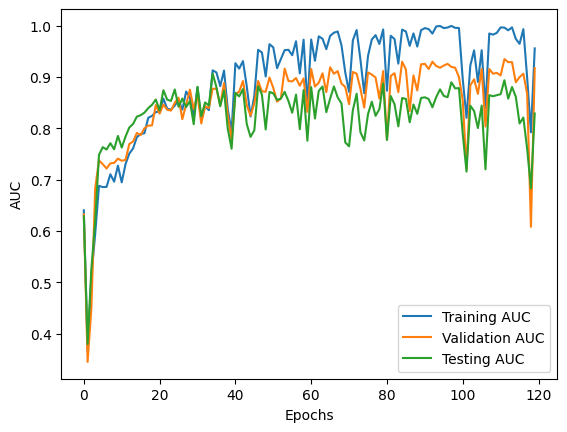

In [114]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(val_log, label='Validation AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [115]:
print("Final Train AUC:", train_log[-1])
print("Final Val AUC:", best_val_auc)
print("Final Test AUC:", best_test_auc)


Final Train AUC: 0.9557226399331662
Final Val AUC: 0.9348370927318296
Final Test AUC: 0.8936925647451963
